In [1]:
#For installing graph-tool see https://gist.github.com/dlozeve/ed59bba8bc8cb9b21e2af36cc9766938
#For handling some error on GTK see https://stackoverflow.com/questions/31021989/error-importing-gtk-module-no-module-named-repository-with-graph-tool

In [2]:
from collections import namedtuple
from graph_tool.all import *
from os import listdir
from os.path import isfile, join, abspath
import xml.etree.ElementTree as ET

/Users/fabiana/anaconda3/envs/graph/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:1480: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [3]:
def read_file(mypath):
    onlyfiles = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
    return onlyfiles

def group_by_key(list_to_group):
    """given a list as l = [[1,2],[1,3], [3,2]]
    returns a dictionary as {1: [2, 3], 3: [2]}
    """
    return {k: list(map(lambda x: x[1], g)) for k,g in  groupby(list_to_group ,lambda x: x[0])}

## Identify role distribution of people involved in the document collection

In [4]:
files = read_file("./data/CAD_TOTALE_100/")

rules = {}

for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    codici_fiscali = root.findall(".//*[@c-fiscale]")
    for l in codici_fiscali:
        #print("ciao")
        if(l.tag in rules.keys()):
            rules[l.tag] = rules[l.tag] + [l.get("c-fiscale")]
        else: 
            rules[l.tag] = [l.get("c-fiscale")]
            
            
items = rules.items()
#print(items)
distribution = {key : [len(list_cf), len(set(list_cf))] for key, list_cf in items}
print("TIPO: [COUNT, DISTINCT] ")
distribution

#unique_cf = set()
#for k,v in items:
#    s = set(v) 
#    print(len(v))
#    unique_cf = unique_cf.union(s)
#print(len(unique_cf))        

TIPO: [COUNT, DISTINCT] 


{'anagrafica-titolare': [233, 203],
 'dati-identificativi': [100, 100],
 'persona-fisica': [160, 160],
 'persona-giuridica': [1, 1],
 'soggetto-controllante': [5, 5]}

## Create Node object

In [5]:
Node = namedtuple('Node', 'id cf edges type desc cat')
g = Graph(directed=False)
type_node = g.new_vertex_property("string")
desc_node = g.new_vertex_property("string")
cf_node = g.new_vertex_property("string")
id_node = g.new_vertex_property("string")
cat_node = g.new_vertex_property('string')
 

In [6]:
files = read_file("./data/CAD_TOTALE_100/")
#print(files[0])
import xml.etree.ElementTree as ET

count = 0
codici_fiscali_map = {}
nodes = []
edges = []

for file in files:
#for file in ['../src/main/resources/CAD_TOTALE_100/029e4880992bf659a4b9469389beddb21affb5c25d85d590d0aabf71ca786668.xml']:
    
    tree = ET.parse(file)
    root = tree.getroot()
    el_forma_giuridica = root.find("dati-identificativi/forma-giuridica")
    forma_giuridica = el_forma_giuridica.text
    forma_giuridica_code = el_forma_giuridica.get("c")
    #dati_identificativi_c_fiscale = root.find("dati-identificativi").get("c-fiscale")
    
    #insert other attributes
    codici_fiscali = root.findall(".//*[@c-fiscale]")
    extracted_cf = [(l.tag, l.get("c-fiscale")) for l in codici_fiscali]
    
    dati_identificativi_c_fiscale = extracted_cf.pop(0)[1]
    
    if dati_identificativi_c_fiscale not in codici_fiscali_map:
        id_current_node = count
        codici_fiscali_map[dati_identificativi_c_fiscale] = id_current_node
        nodes.append(Node(id = id_current_node, 
                cf = dati_identificativi_c_fiscale, 
                edges= extracted_cf, 
                desc = forma_giuridica,
                cat = "triangle",
                type = 'SOCIETA' 
               ))
        count +=1 
    else:
        id_current_node = codici_fiscali_map[dati_identificativi_c_fiscale]
        nodes[id_current_node] = (Node(id = id_current_node, 
                cf = dati_identificativi_c_fiscale, 
                edges= extracted_cf, 
                desc = forma_giuridica,
                cat = "triangle",
                type = 'SOCIETA' 
               ))
    
    for type_cf, cf in extracted_cf:
        if(cf not in codici_fiscali_map):
            codici_fiscali_map[cf] = count
            nodes.append(Node(id = count, cf = cf, edges = [], desc = "", cat = "circle", type = "PERSONA"))
            count += 1
            
    new_edges = map(lambda x: (id_current_node, codici_fiscali_map[x[1]], x[0]), extracted_cf)        
    edges.extend(new_edges)  
    
    
#print(len(extracted_cf))    
#print(len(nodes))
print('generated %d nodes' %count)
print('generated %d edges' %len(edges))

generated 380 nodes
generated 399 edges


## Create a simple graph from a node list


In [7]:
graph_size = len(nodes)
x = g.add_vertex(graph_size)
g.add_edge_list(edges)
print("Adding %d nodes and %d edges" %(len(list(x)),len(edges)))

Adding 380 nodes and 399 edges


In [8]:
print(edges[0:3])
print(nodes[0:3])

[(0, 1, 'persona-fisica'), (0, 2, 'persona-fisica'), (0, 3, 'persona-fisica')]
[Node(id=0, cf='029e4880992bf659a4b9469389beddb21affb5c25d85d590d0aabf71ca786668', edges=[('persona-fisica', 'dd24996015eb3e3c41f87280e4bbc49b4039c42d0b21ae31e3fcb3bab3b06c99'), ('persona-fisica', 'abe62ad46d05341736c5927e283fca86291e29a783e45937ae80a28c068f2eea'), ('persona-fisica', '011298f86adcb140924ac214e30a080f30c61b2f5948930ae1004b54d6340044')], type='SOCIETA', desc="SOCIETA' COOPERATIVA", cat='triangle'), Node(id=1, cf='dd24996015eb3e3c41f87280e4bbc49b4039c42d0b21ae31e3fcb3bab3b06c99', edges=[], type='PERSONA', desc='', cat='circle'), Node(id=2, cf='abe62ad46d05341736c5927e283fca86291e29a783e45937ae80a28c068f2eea', edges=[], type='PERSONA', desc='', cat='circle')]


## Add graph properties

In [9]:
for n in nodes:
#    #type_node[g.vertex(v)] = nodes[v].type
    index = n.id
    cat_node[index] = n.cat
    cf_node[index] = n.cf
    type_node[index] = n.type
    desc_node[index] = n.desc

g.vertex_properties["category"] = cat_node
g.vertex_properties["cf"] = cf_node
g.vertex_properties["type"] = type_node
g.vertex_properties["description"] = desc_node


from graph_tool.all import graph_draw, Graph 
#graph draw uses sfdp - multiscale version of fdp for the layout of large graphs.
loaded_graph = load_graph(name)
graph_draw(
    loaded_graph,
    vertex_shape=cat_node,
    #vertex_text=cf_node,
    #vertex_font_size = 0.1,
    #output_size=(200,200),
    output="./graph1.png"
)  


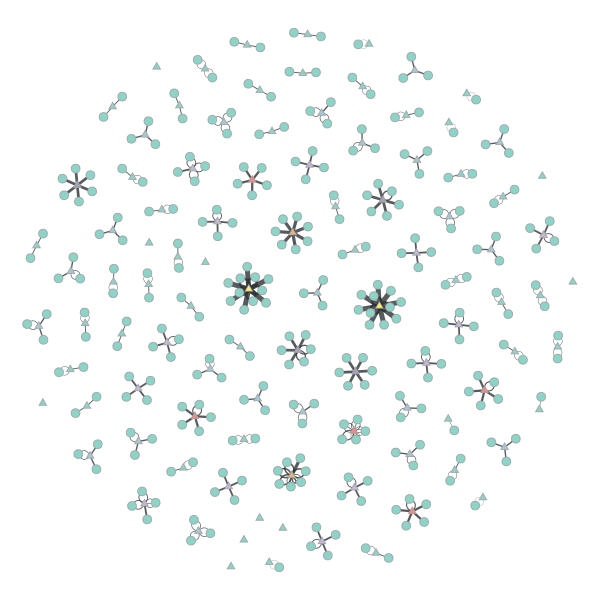

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x12d945dd8, at 0x12d979cc0>

In [10]:
from graph_tool.all import betweenness
bv, be = betweenness(g)
be.a /= be.a.max() / 5

graph_draw(g, vertex_shape=cat_node, vertex_fill_color=bv, edge_pen_width=be, output="graph2.pdf")

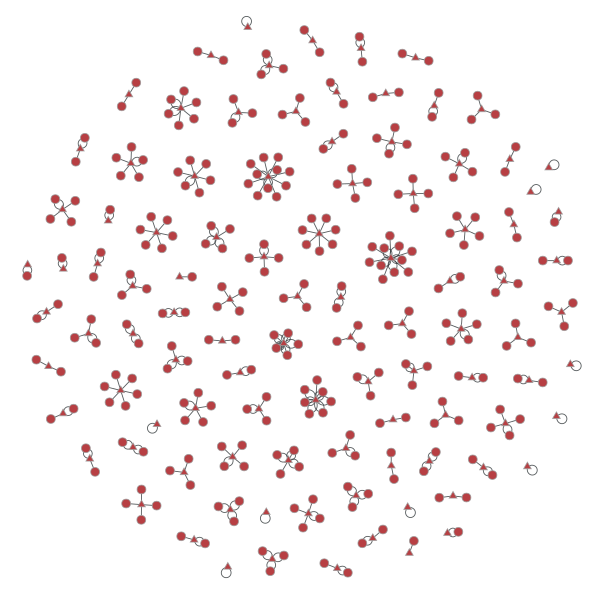

In [11]:

pos = graph_draw(
    g,
    vertex_shape=cat_node,
    #vertex_text=cf_node,
    #vertex_font_size = 0.1,
    #output_size=(200,200),
    output="./graph1.png"
)  



In [12]:
v_x = g.new_vertex_property("double")
v_y = g.new_vertex_property("double")
for v in g.get_vertices():
    #print(pos[v][0])
    v_x[v] = pos[v][0]
    v_y[v] = pos[v][1]

g.vertex_properties["x"] = v_x
g.vertex_properties["y"] = v_y

In [13]:
name = "CAD_TOTALE_100.xml"
g.save(name)

In [14]:
## Visualize data with Plotly

In [20]:
import plotly.plotly as py
from plotly.graph_objs import *
edge_trace = Scatter(
    x=[],
    y=[],
    text=[],
    line=Line(width=0.5,color='#888'),
    hoverinfo='text',
    mode='lines')

for edge in g.get_edges():
    x = edge[0]
    y = edge[1]
    x0 = pos[x][0]
    y0 = pos[x][1]
    x1 = pos[y][0]
    y1 = pos[y][1]
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]
    edge_trace['text'].append('pippo')

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in g.get_vertices():
    x = pos[node][0]
    y = pos[node][1]
    node_trace['x'].append(x)
    node_trace['y'].append(y)


In [21]:
from graph_tool.spectral import adjacency
mat = adjacency(g).tolil()
rows = mat.rows.copy()

In [22]:
for node in g.get_vertices():
    node_trace['marker']['color'].append(len(rows[node]))
    node_info = '# of connections: {0} <br> cf: {1} <br> type: {2} <br> desc: {3}'.format( str(len(rows[node])), cf_node[node], type_node[node], desc_node[node])
    node_trace['text'].append(node_info)


In [23]:
py.sign_in("chrispolo", "89nned6csl")


In [24]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Network graph made with Python',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='network')